In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import spacy
import string
from pprint import pprint

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.collocations import *
import collections
import contractions
# from pycontractions import Contractions

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
#import data
data = pd.read_csv('caring_data.csv')
data.head()

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type
0,0,I am a friend or relative of a current/past re...,Lizzy49,2018-07-07,5,This is a residence for mentally challenged me...,Plymouth,Schwabe Residential Home,Offers Assisted Living
1,0,I visited this facility,moomamma,2014-03-06,4,I have heard such good comments about Jackson ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
2,1,I am/was a resident of this facility,Biker_Momma45,2014-03-05,5,I had my Dad in this facility recently and he ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
3,2,I am/was a resident of this facility,solongdad,2012-09-26,3,I found not all staff friendly. One nurse was ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
4,0,I am a friend or relative of a current/past re...,Peggy,2018-04-30,5,"Mom really likes Oak Manor, and everything has...",Jackson,Oak Manor,Offers Assisted Living


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11980 entries, 0 to 11979
Data columns (total 9 columns):
Unnamed: 0               11980 non-null int64
reviewer_type            11980 non-null object
reviewer_name            11979 non-null object
date                     11980 non-null object
star                     11980 non-null int64
review                   11980 non-null object
location                 11980 non-null object
name_of_senior_living    11980 non-null object
type                     11980 non-null object
dtypes: int64(2), object(7)
memory usage: 842.5+ KB


In [11]:
data.describe()

,Unnamed: 0,star
count,11980.000000,11980.000000
mean,8.995910,4.272204
std,9.639026,1.010230
min,0.000000,1.000000
25%,2.000000,4.000000
50%,6.000000,5.000000
75%,13.000000,5.000000
max,102.000000,5.000000


## Exploratory Data Analysis

In [12]:
data.head()

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type
0,0,I am a friend or relative of a current/past re...,Lizzy49,2018-07-07,5,This is a residence for mentally challenged me...,Plymouth,Schwabe Residential Home,Offers Assisted Living
1,0,I visited this facility,moomamma,2014-03-06,4,I have heard such good comments about Jackson ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
2,1,I am/was a resident of this facility,Biker_Momma45,2014-03-05,5,I had my Dad in this facility recently and he ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
3,2,I am/was a resident of this facility,solongdad,2012-09-26,3,I found not all staff friendly. One nurse was ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care
4,0,I am a friend or relative of a current/past re...,Peggy,2018-04-30,5,"Mom really likes Oak Manor, and everything has...",Jackson,Oak Manor,Offers Assisted Living


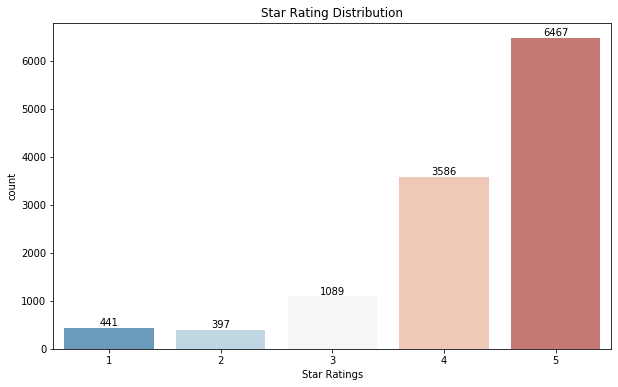

In [13]:
x=data['star'].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8, palette = 'RdBu_r')
plt.title("Star Rating Distribution")
plt.ylabel('count')
plt.xlabel('Star Ratings')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

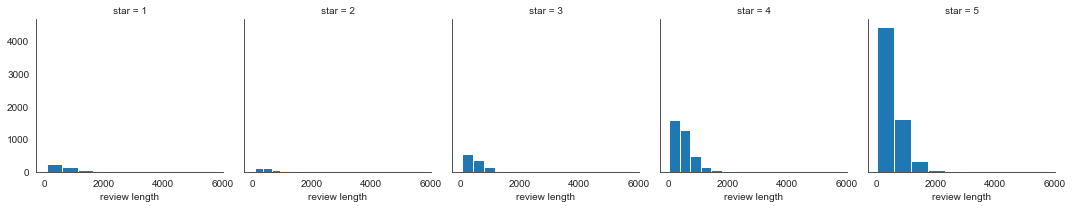

In [14]:
data['review length'] = data['review'].apply(len)

sns.set_style('white')
g = sns.FacetGrid(data, col= 'star')
g.map(plt.hist, 'review length');

`Note: Users tend to leave shorter review when they give more stars.`

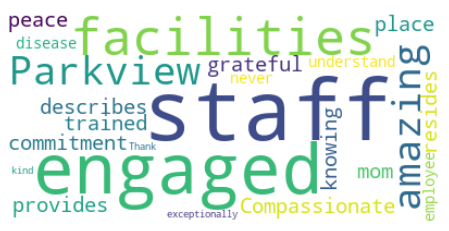

In [15]:
text = data.query('star == 5').review[10]

# Create and generate a word cloud image:
# wordcloud = WordCloud().generate(text)

# # Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

stopwords = set(STOPWORDS)
# stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize = [8,4])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


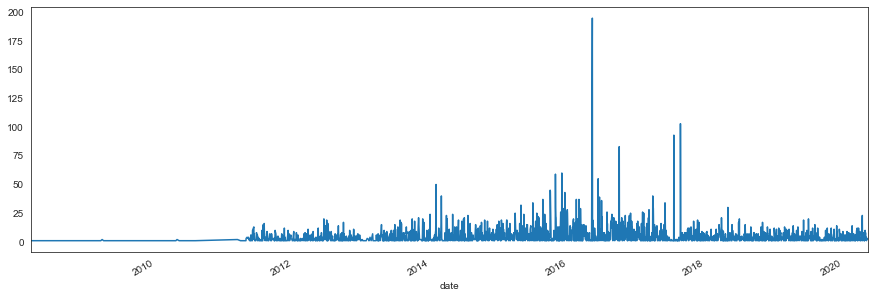

In [16]:
#time series
#num of review over time
data['date'] = pd.to_datetime(data['date'])
groupby_posted_on = data.groupby('date').count()
groupby_posted_on.review.plot(figsize = (15, 5));

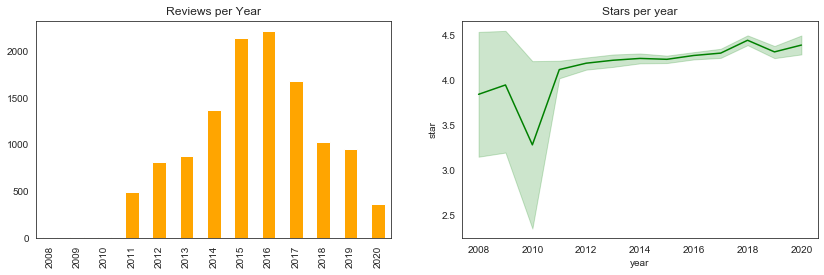

In [17]:
data['year'] = data['date'].dt.year

fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
data.year.value_counts().sort_index().plot.bar(title='Reviews per Year', ax=axes[0], color = 'orange');
sns.lineplot(x='year', y='star', data=data, ax=axes[1], color = 'green')
axes[1].set_title('Stars per year');

In [18]:
data.groupby('location').review.count().sort_values()

location
Harbor City       1
Martinez          1
Ladera Ranch      1
Escalon           1
Los Osos          1
               ... 
Santa Rosa      220
San Diego       229
San Jose        249
Roseville       274
Fresno          347
Name: review, Length: 338, dtype: int64

# Text Preprocessing

In [19]:
from nltk.corpus import stopwords

def tokenize(data, col):
    
    data['review_no_contract'] = data[col].apply(lambda x : [contractions.fix(word) for word in x.split()])
    data['review_new'] = [' '.join(map(str, l)) for l in data['review_no_contract']]
    target_words = []
    for review in data.review_new:
        target_words.extend(nltk.word_tokenize(review))

    words_no_punc = [w.lower() for w in target_words if not w in string.punctuation]
    stop_words = set(stopwords.words('english'))  
    not_stopwords = {'not', 'no', 'nor'} 
    final_stop_words = set([word for word in stop_words if word not in not_stopwords])
    words_no_stopwords = [w for w in words_no_punc if not w in final_stop_words] 
    
    lemmatizer = WordNetLemmatizer()
    lem_words = [lemmatizer.lemmatize(w) for w in words_no_stopwords]
    final_words = [w for w in words_no_stopwords if w in lem_words]
    return(final_words)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    d = words_df.nlargest(columns = "count", n = terms) 
    plt.figure(figsize = (20,5))
    ax = sns.barplot(data = d, x = "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

# nlp = spacy.load('en', disable=['parser', 'ner'])
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

# nlp = spacy.load('en', disable=['parser', 'ner'])
# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     output_text = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         output_text.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
#     return output_text



In [20]:
token_data = tokenize(data, 'review')
token_data 

['residence',
 'mentally',
 'challenged',
 'men',
 'son',
 'several',
 'improved',
 'tremendously',
 'past',
 'excellent',
 'home',
 'many',
 'enjoy',
 'especially',
 'also',
 'go',
 'least',
 'one',
 'trip',
 'year',
 'disneyland',
 'shared',
 'nice',
 'decorate',
 'area',
 'wonderful',
 'people',
 'field',
 'special',
 'education',
 'many',
 'understand',
 'extremely',
 'well',
 'unfortunately',
 'not',
 'many',
 'like',
 'fortunate',
 'find',
 'would',
 'recommend',
 'anyone',
 'opening',
 'far',
 'heard',
 'good',
 'jackson',
 'stay',
 'long',
 'time',
 'look',
 'happy',
 'dad',
 'facility',
 'recently',
 'given',
 'best',
 'care',
 'amp',
 'amp',
 'love',
 'support',
 'staff',
 'beyond',
 'really',
 'read',
 'understand',
 'final',
 'dementia',
 'judgement',
 'thank',
 'daily',
 'basis',
 'found',
 'not',
 'staff',
 'friendly',
 'one',
 'nurse',
 'actually',
 'oblivious',
 'going',
 'crisis',
 'father-in-law',
 'difficulty',
 'breathing',
 'took',
 'long',
 'time',
 'answer',
 'ca

In [21]:
token_data = np.array(token_data)

/Users/joanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/joanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


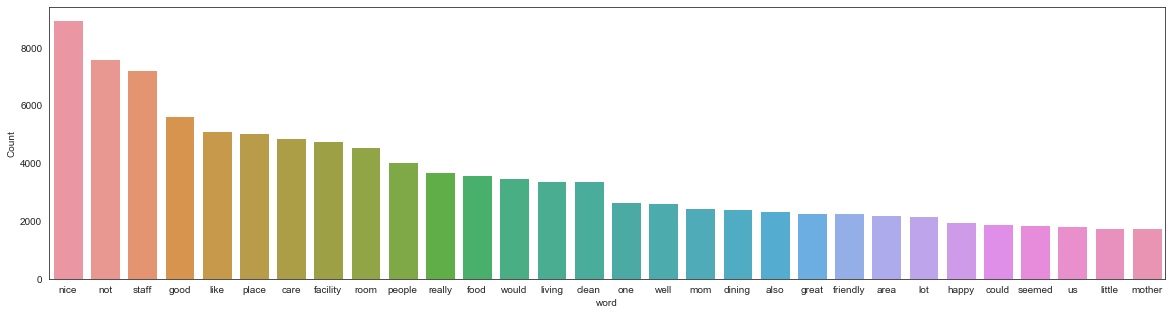

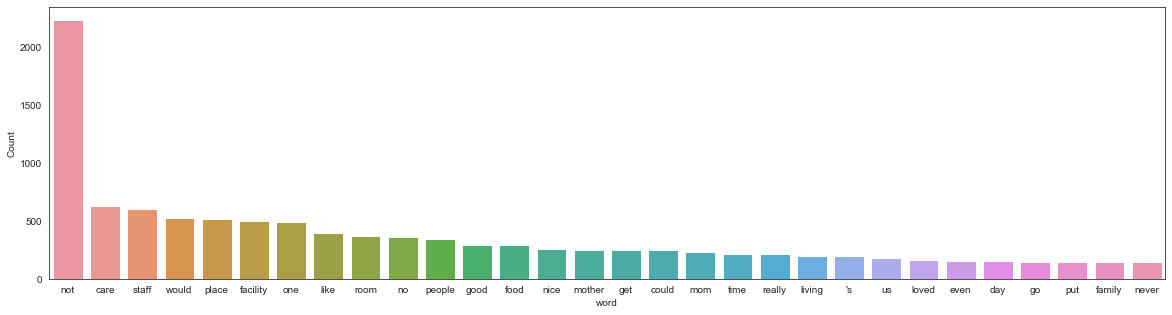

In [22]:
#split good and bad stars reviews and see frequent words
good_star_data = data.query('star >= 4')
bad_star_data = data.query('star < 3')

freq_words(tokenize(good_star_data, 'review'))
freq_words(tokenize(bad_star_data, 'review'))

# Vader/TextBlob Sentiment Analysis

In [836]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [839]:
analyser = SentimentIntensityAnalyzer()
tag = []
score = []
for i in range(len(data.review)): 
    snt = analyser.polarity_scores(data.review[i])
    score.append(snt['compound'])
    if (snt['compound']) >= 0.1:
        tag.append('pos')
    elif (snt['compound']) <= -0.1:    
        tag.append('neg')
    else:
        tag.append('neu')

In [841]:
data['tag'] = tag
data['polarity_score'] = score
data.describe()

,Unnamed: 0,star,review length,year,polarity_score
count,11980.000000,11980.000000,11980.000000,11980.000000,11980.000000
mean,8.995910,4.272204,529.766361,2015.539733,0.824434
std,9.639026,1.010230,397.423977,2.255899,0.354212
min,0.000000,1.000000,5.000000,2008.000000,-0.995900
25%,2.000000,4.000000,272.000000,2014.000000,0.862500
50%,6.000000,5.000000,422.000000,2016.000000,0.950900
75%,13.000000,5.000000,670.250000,2017.000000,0.979400
max,102.000000,5.000000,5725.000000,2020.000000,0.999600


In [842]:
tmp = data.pivot_table(index = 'star', columns = 'tag', values = 'review', aggfunc = 'count')
cm = sns.light_palette('blue', as_cmap=True, reverse = True)

s = tmp.style.background_gradient(cmap=cm, low=0, high=1, axis=0)
s

tag,neg,neu,pos
star,,,
1,223,20,198
2,115,21,261
3,111,27,951
4,52,24,3510
5,12,28,6427


In [843]:
pd.set_option('display.max_colwidth', -1)
print(data.query('star == 1 & tag == "pos"').review[:1])

257    We waited half an hour at Carlton for the representative to come, and I was about ready to walk out the door when she showed up. We had an appointment, and they were half an hour late, but it wasn’t the gal we had an appointment with; it was somebody else. They were working on the entrance. I came from an insurance background, and they had no safety cones up. It was unsafe, and I did not like the rooms. They had this big and strange open space between the bedroom and the living room, and they were very narrow rooms that if you put a couch in there, I don’t know if you could put anything else hardly across the table except a TV hanging on the wall. The room seemed almost like a bowling alley. There were no balconies, and the people were not very friendly. They need to improve on keeping their appointments, which would be nice. Safety for the residents or safety for anybody walking through the front door would be another thing, and then cleanliness is another thing. The rooms cert

In [844]:
#TextBlob
from textblob import TextBlob

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity'] = data.review.apply(detect_polarity)
data.head(1)

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type,review length,year,review_no_contract,review_new,tag,polarity_score,polarity
0,0,I am a friend or relative of a current/past resident,Lizzy49,2018-07-07,5,"This is a residence for mentally challenged men and women. Our son had been there for several years and has improved tremendously over the past few years,\r\nIt is an excellent home with many activities for the residents to enjoy, especially sports. They also go on at least one trip a year such as Disneyland.\r\n The rooms are shared and are very nice. The residents can decorate their area with their own choices.\r\nThe caregivers are wonderful people who have been in the field of special education for many years and understand the residents extremely well.\r\nUnfortunately there are not many homes like this but we were fortunate to find it,\r\nWe would recommend it to anyone if they have an opening and those are few and far between.",Plymouth,Schwabe Residential Home,Offers Assisted Living,736,2018,"[This, is, a, residence, for, mentally, challenged, men, and, women., Our, son, had, been, there, for, several, years, and, has, improved, tremendously, over, the, past, few, years,, It, is, an, excellent, home, with, many, activities, for, the, residents, to, enjoy,, especially, sports., They, also, go, on, at, least, one, trip, a, year, such, as, Disneyland., The, rooms, are, shared, and, are, very, nice., The, residents, can, decorate, their, area, with, their, own, choices., The, caregivers, are, wonderful, people, who, have, been, in, the, field, of, special, education, for, many, years, and, understand, the, residents, extremely, well., Unfortunately, there, are, not, ...]","This is a residence for mentally challenged men and women. Our son had been there for several years and has improved tremendously over the past few years, It is an excellent home with many activities for the residents to enjoy, especially sports. They also go on at least one trip a year such as Disneyland. The rooms are shared and are very nice. The residents can decorate their area with their own choices. The caregivers are wonderful people who have been in the field of special education for many years and understand the residents extremely well. Unfortunately there are not many homes like this but we were fortunate to find it, We would recommend it to anyone if they have an opening and those are few and far between.",pos,0.9489,0.183885


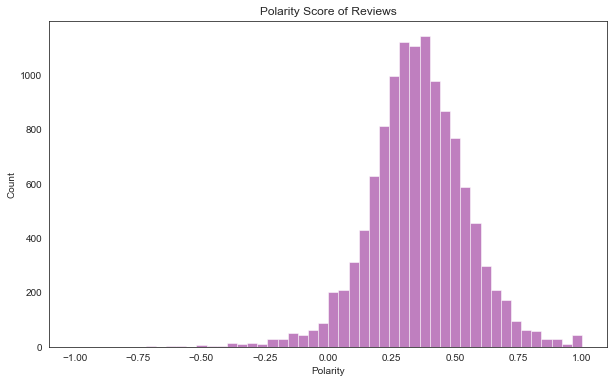

In [846]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(data.polarity, num_bins, facecolor='purple', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Polarity Score of Reviews')
plt.show();

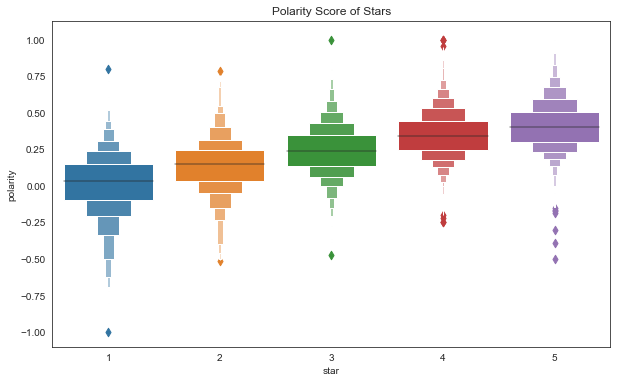

In [847]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='star', y='polarity', data=data)
plt.title('Polarity Score of Stars')
plt.show();

In [653]:
data[(data.star == 1)  & (data.polarity > 0.5)].head()

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type,review length,topic,tag,polarity_score,year,polarity
2407,1,I visited this facility,John,2019-01-13,1,"I didn't like anything about Signature Senior Living. The staff wasn't accommodating at all. I didn't like the menu, too. I didn't like the place. The staff wasn't very nice or hospitable. I didn't think the place was well maintained at all. It wasn't that clean either.",Brooklyn,Signature Senior Living,"Offers Assisted Living, Independent Living, and Memory Care",270,1,neg,-0.7927,2019,0.573333
3042,16,I visited this facility,Rita,2018-09-01,1,"Windsor was fine and I liked the convenience of being in Glendale. It's close to things, but it didn't have many activities for people. The staff member who gave me the tour was alright, but wasn't anything special. I was just not that impressed. It's sort of a drab place so it needs to be more cheerful with its décor.",Glendale,Windsor,Offers Assisted Living and Continuing Care Communities,320,1,pos,0.5819,2018,0.539116
3852,7,I visited this facility,joan walter,2011-11-17,1,An excellent place for elders needing assistance ... just over the amount available\n,Ukiah,Mountain View,Offers Assisted Living,84,1,pos,0.5719,2011,0.700000
8897,1,I visited this facility,Care4ma,2015-09-30,1,"Took a tour recently, great care givers but smelly, lots of pets that's aren't potty trained. Couldn't wait to get out of there.\n",Atascadero,"A TOUCH ABOVE CARE, INC.",Offers Assisted Living,129,1,pos,0.6705,2015,0.800000


In [652]:
data[(data.star == 3)  & (data.polarity == 1)].review

4448    The Regents was in the process of updating. Everybody was wonderful, except the building itself needs upgrading. The rooms looked wonderful, and I walked to all of them from exercise classes and bowling\n
Name: review, dtype: object

In [651]:
data[(data.star == 5)  & (data.polarity < -0.4)].head(10)

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type,review length,topic,tag,polarity_score,year,polarity
1676,9,I visited this facility,Visitor 105,2016-05-10,5,"Oakmont of Fresno was immaculate. I’d give it 5 stars for its facilities, the knowledgeable staff, the amount of services, the dining, the rooms, and air conditioning, but it’s too expensive.\n",Fresno,Oakmont of Fresno,"Offers Assisted Living, Independent Living, and Memory Care",192,1,neu,0.0,2016,-0.5


# Topic Modeling

In [26]:
#another processing
review_list = data.review.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

review_words = list(sent_to_words(review_list))

print(review_words[:1])

[['this', 'is', 'residence', 'for', 'mentally', 'challenged', 'men', 'and', 'women', 'our', 'son', 'had', 'been', 'there', 'for', 'several', 'years', 'and', 'has', 'improved', 'tremendously', 'over', 'the', 'past', 'few', 'years', 'it', 'is', 'an', 'excellent', 'home', 'with', 'many', 'activities', 'for', 'the', 'residents', 'to', 'enjoy', 'especially', 'sports', 'they', 'also', 'go', 'on', 'at', 'least', 'one', 'trip', 'year', 'such', 'as', 'disneyland', 'the', 'rooms', 'are', 'shared', 'and', 'are', 'very', 'nice', 'the', 'residents', 'can', 'decorate', 'their', 'area', 'with', 'their', 'own', 'choices', 'the', 'caregivers', 'are', 'wonderful', 'people', 'who', 'have', 'been', 'in', 'the', 'field', 'of', 'special', 'education', 'for', 'many', 'years', 'and', 'understand', 'the', 'residents', 'extremely', 'well', 'unfortunately', 'there', 'are', 'not', 'many', 'homes', 'like', 'this', 'but', 'we', 'were', 'fortunate', 'to', 'find', 'it', 'we', 'would', 'recommend', 'it', 'to', 'anyone

In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(review_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[review_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[review_words[0]]])

['this', 'is', 'residence', 'for', 'mentally', 'challenged', 'men', 'and', 'women', 'our', 'son', 'had', 'been', 'there', 'for', 'several', 'years', 'and', 'has', 'improved', 'tremendously', 'over', 'the', 'past', 'few', 'years', 'it', 'is', 'an', 'excellent', 'home', 'with', 'many', 'activities', 'for', 'the', 'residents', 'to', 'enjoy', 'especially', 'sports', 'they', 'also', 'go', 'on', 'at', 'least', 'one', 'trip', 'year', 'such', 'as', 'disneyland', 'the', 'rooms', 'are', 'shared', 'and', 'are', 'very', 'nice', 'the', 'residents', 'can', 'decorate', 'their', 'area', 'with', 'their', 'own', 'choices', 'the', 'caregivers', 'are', 'wonderful', 'people', 'who', 'have', 'been', 'in', 'the', 'field', 'of', 'special', 'education', 'for', 'many', 'years', 'and', 'understand', 'the', 'residents', 'extremely', 'well', 'unfortunately', 'there', 'are', 'not', 'many', 'homes', 'like', 'this', 'but', 'we', 'were', 'fortunate', 'to', 'find', 'it', 'we', 'would', 'recommend', 'it', 'to', 'anyone'

In [28]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'VERB', 'ADJ', 'ADV']): #'NOUN', 'VERB'
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Remove Stop Words
review_words_nostops = remove_stopwords(review_words)

# Form Bigrams
review_words_bigrams = make_bigrams(review_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun and vb  (noun, adj, vb, adv)
data_lemmatized = lemmatization(review_words_bigrams, allowed_postags=['NOUN', 'ADJ']) #'NOUN', 'VERB'

print(data_lemmatized[:1])

[['man', 'woman', 'son', 'several', 'year', 'past', 'year', 'excellent', 'home', 'many', 'activity', 'resident', 'sport', 'least', 'trip', 'year', 'disneyland', 'room', 'nice', 'resident', 'decorate', 'area', 'choice', 'caregiver', 'wonderful', 'people', 'field', 'special', 'education', 'many', 'year', 'resident', 'many', 'home', 'fortunate', 'find']]


In [30]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 4)]]


In [31]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = 4, 
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = 'auto',
                                            eval_every = 0.5,
                                            per_word_topics = True)

In [32]:
#Noun only
# Print the Keyword in the 10 topics 
pprint(lda_model.print_topics(num_words= 15))
doc_lda = lda_model[corpus]

[(0,
  '0.094*"room" + 0.090*"nice" + 0.061*"place" + 0.048*"staff" + '
  '0.036*"people" + 0.035*"facility" + 0.034*"clean" + 0.028*"area" + '
  '0.026*"dining" + 0.022*"friendly" + 0.019*"little" + 0.017*"small" + '
  '0.015*"beautiful" + 0.012*"helpful" + 0.012*"big"'),
 (1,
  '0.085*"care" + 0.063*"facility" + 0.032*"staff" + 0.020*"memory" + '
  '0.020*"time" + 0.019*"patient" + 0.018*"member" + 0.014*"help" + '
  '0.013*"level" + 0.012*"able" + 0.011*"dementia" + 0.011*"day" + '
  '0.010*"hospital" + 0.010*"month" + 0.010*"need"'),
 (2,
  '0.062*"mom" + 0.054*"family" + 0.041*"resident" + 0.040*"home" + '
  '0.039*"year" + 0.026*"mother" + 0.025*"staff" + 0.014*"many" + '
  '0.011*"caregiver" + 0.011*"love" + 0.011*"environment" + 0.010*"management" '
  '+ 0.010*"life" + 0.009*"quality" + 0.009*"safe"'),
 (3,
  '0.061*"good" + 0.040*"food" + 0.037*"activity" + 0.029*"resident" + '
  '0.022*"lot" + 0.021*"thing" + 0.019*"great" + 0.016*"happy" + '
  '0.015*"apartment" + 0.014*"com

In [33]:
 lda_model.show_topics(formatted=False)

[(0,
  [('room', 0.09369061),
   ('nice', 0.08978548),
   ('place', 0.06082634),
   ('staff', 0.04805695),
   ('people', 0.03640217),
   ('facility', 0.03477327),
   ('clean', 0.033639114),
   ('area', 0.028377099),
   ('dining', 0.02571657),
   ('friendly', 0.022271978)]),
 (1,
  [('care', 0.08480102),
   ('facility', 0.06313507),
   ('staff', 0.032440785),
   ('memory', 0.020427423),
   ('time', 0.019996373),
   ('patient', 0.018672833),
   ('member', 0.01835581),
   ('help', 0.013550185),
   ('level', 0.013199771),
   ('able', 0.012217917)]),
 (2,
  [('mom', 0.06217981),
   ('family', 0.054021902),
   ('resident', 0.04076371),
   ('home', 0.039951712),
   ('year', 0.038850177),
   ('mother', 0.02614027),
   ('staff', 0.025356883),
   ('many', 0.014285636),
   ('caregiver', 0.010670918),
   ('love', 0.010622306)]),
 (3,
  [('good', 0.06055851),
   ('food', 0.03950969),
   ('activity', 0.03678175),
   ('resident', 0.028844962),
   ('lot', 0.02199526),
   ('thing', 0.021346502),
   ('g

In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. 0 or lower. the lower the better.

# Compute Coherence Score 
#if the cluster is far from each other, then the coherence score is close to 1. If not, close to 0.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.455332544636655

Coherence Score:  0.5431733629811601


In [858]:
# Visualize the topics - Only Noun
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/joanna/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.099251  0.291151  1       1        37.003044
0      0.341990  0.027820  2       1        33.420601
1     -0.023708 -0.258453  3       1        17.110340
2     -0.219031 -0.060518  4       1        12.466016, topic_info=    Category         Freq      Term        Total  loglift  logprob
19   Default  9315.000000  room      9315.000000  30.0000  30.0000
15   Default  8926.000000  nice      8926.000000  29.0000  29.0000
33   Default  4322.000000  care      4322.000000  28.0000  28.0000
36   Default  6671.000000  facility  6671.000000  27.0000  27.0000
89   Default  6419.000000  place     6419.000000  26.0000  26.0000
..       ...          ...    ...             ...      ...      ...
251  Topic4   270.336853   visit     548.721191   1.3742  -4.9212 
20   Topic4   233.487671   several   508.436218   1.3040  -5.0678 
190  Topic4   219.554794   first     474.498657   1.3115  -5.1293 
32   Topic4   261.875183   time      2551.250244 -0.1943  -4.9530 
358  Topic4   214.659821   director  567.833679   1.1094  -5.1519 

[213 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
139   1      0.013912  able     
139   2      0.199820  able     
139   3      0.786635  able     
0     1      0.951298  activity 
0     2      0.048634  activity 
...  ..           ...       ... 
26    4      0.062179  wonderful
312   1      0.248103  work     
312   3      0.670957  work     
312   4      0.079824  work     
27    4      0.999691  year     

[245 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

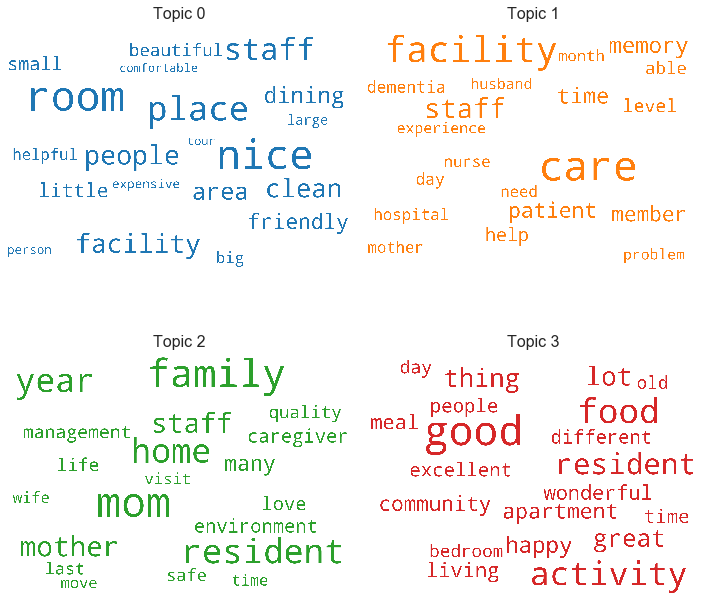

In [861]:
#visualization

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words = 20)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

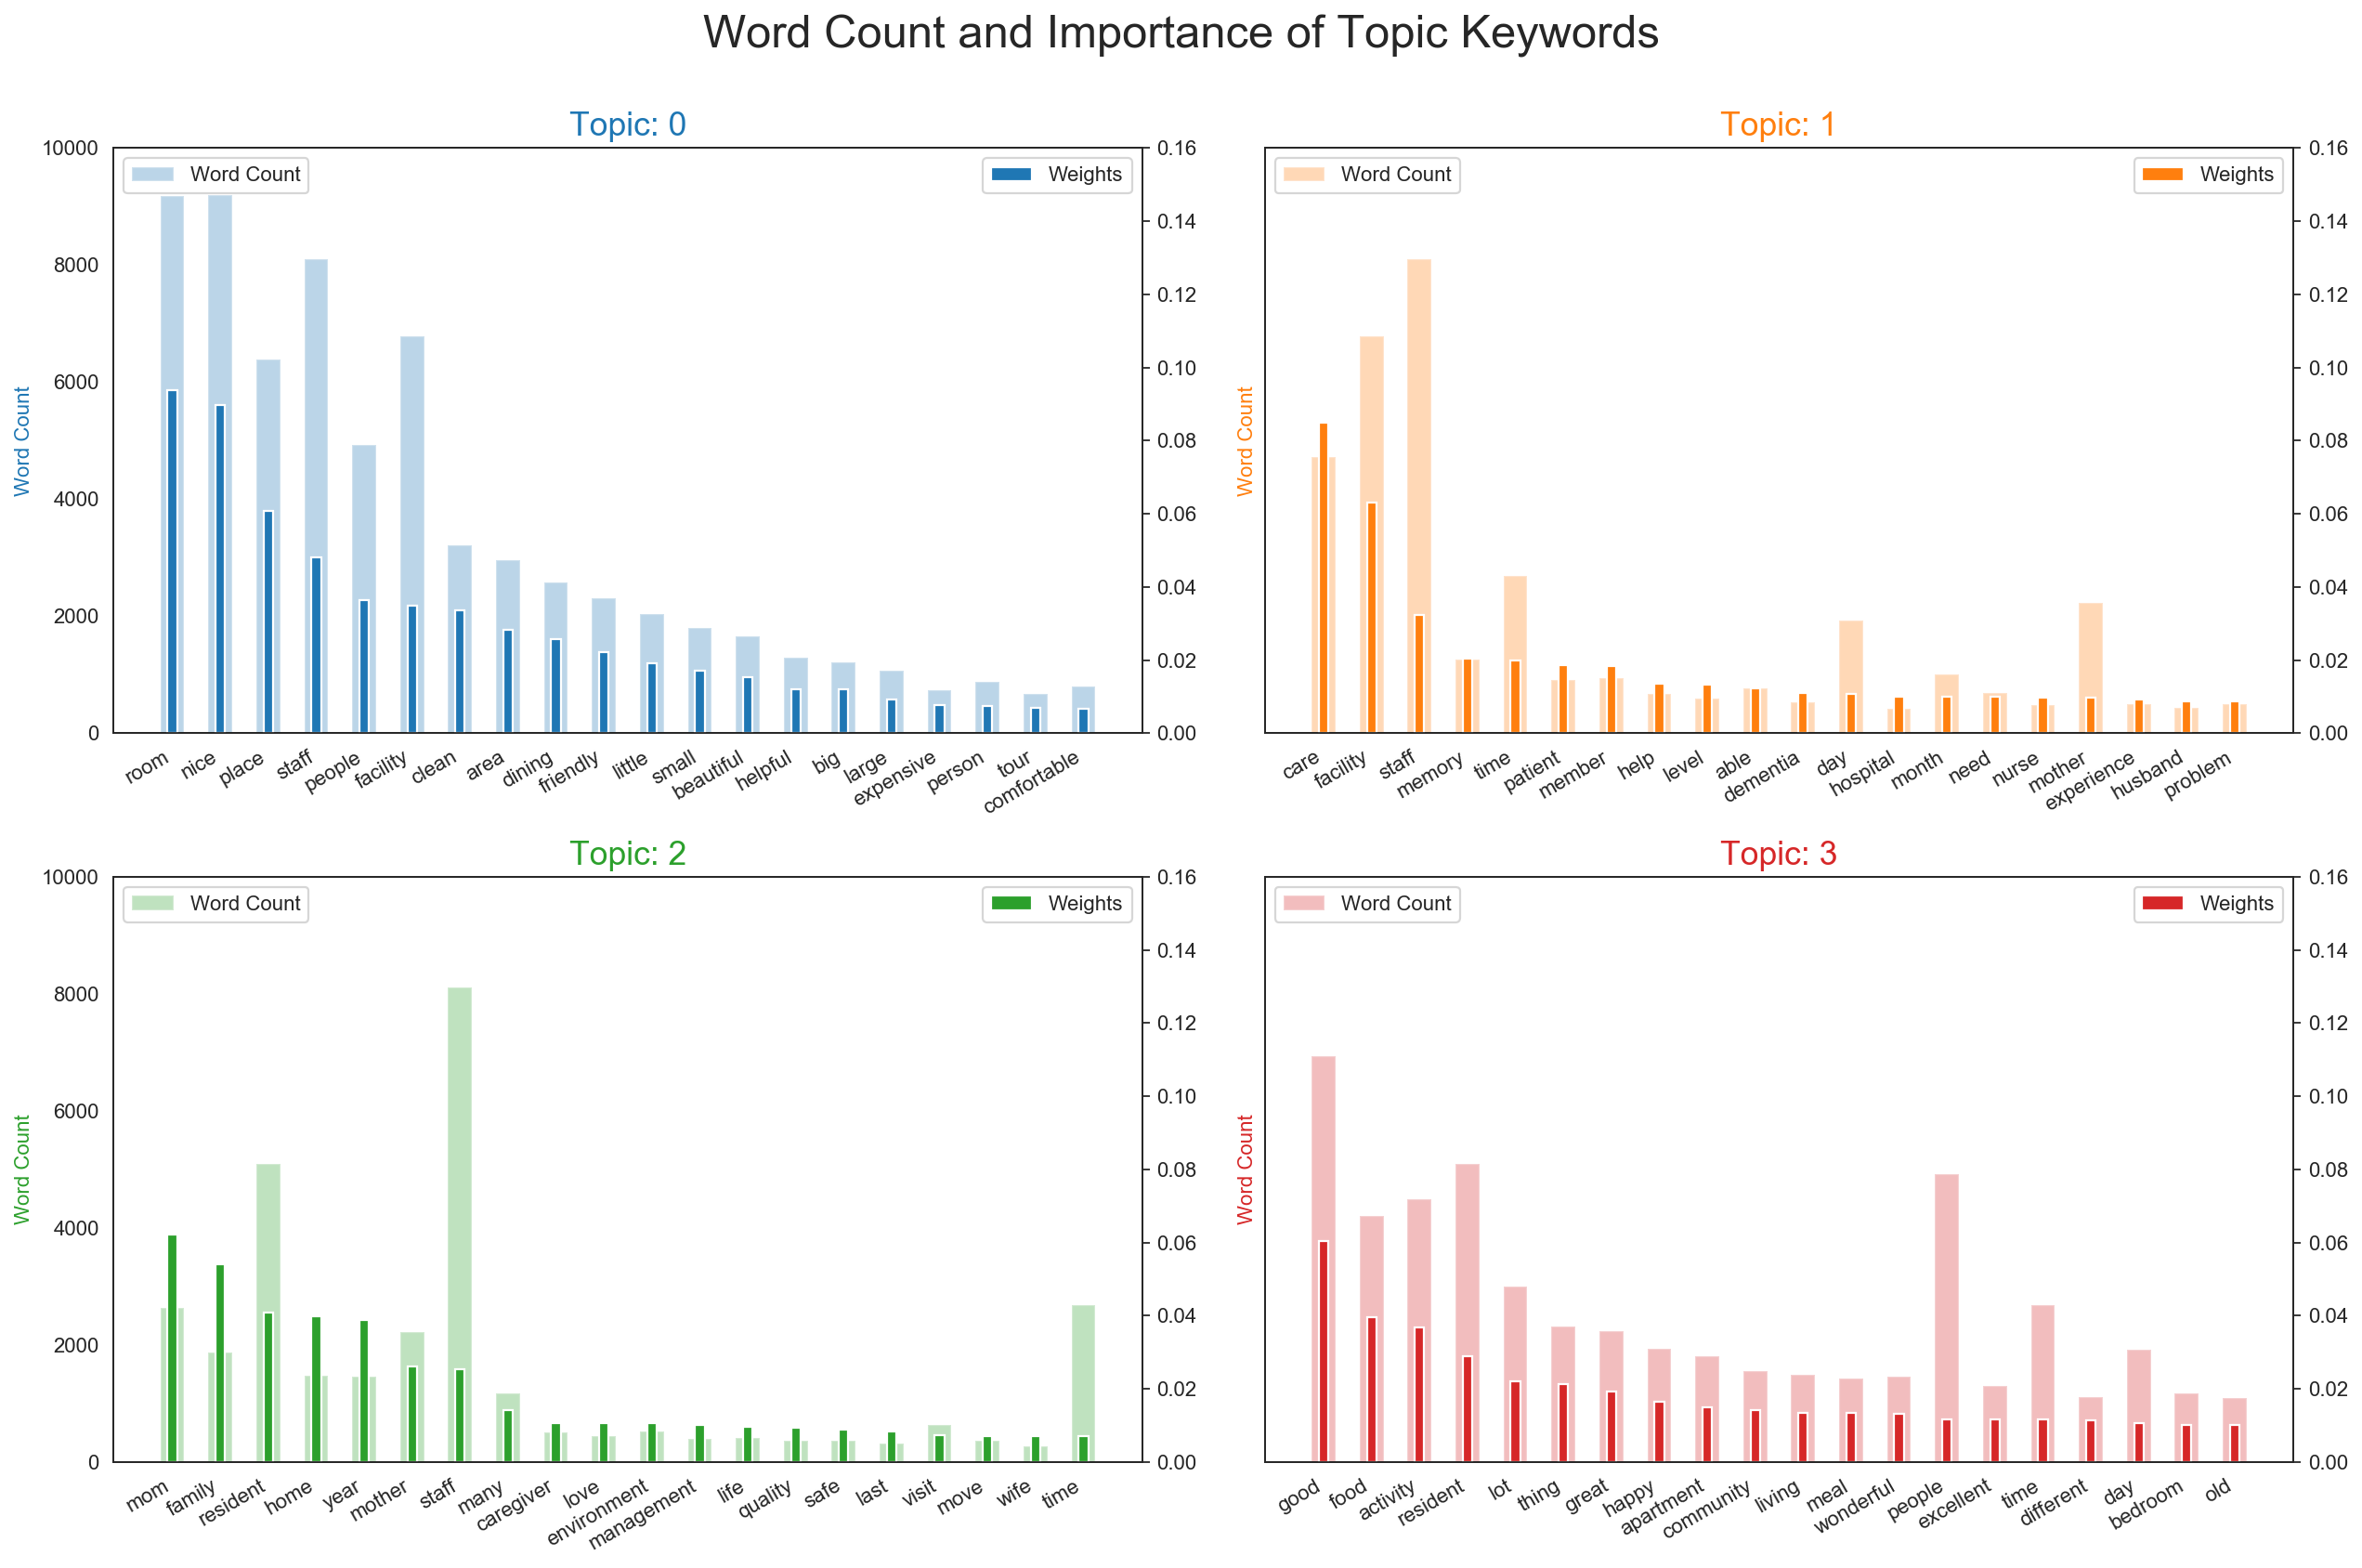

In [862]:
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_words = 20)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])   

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.160); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

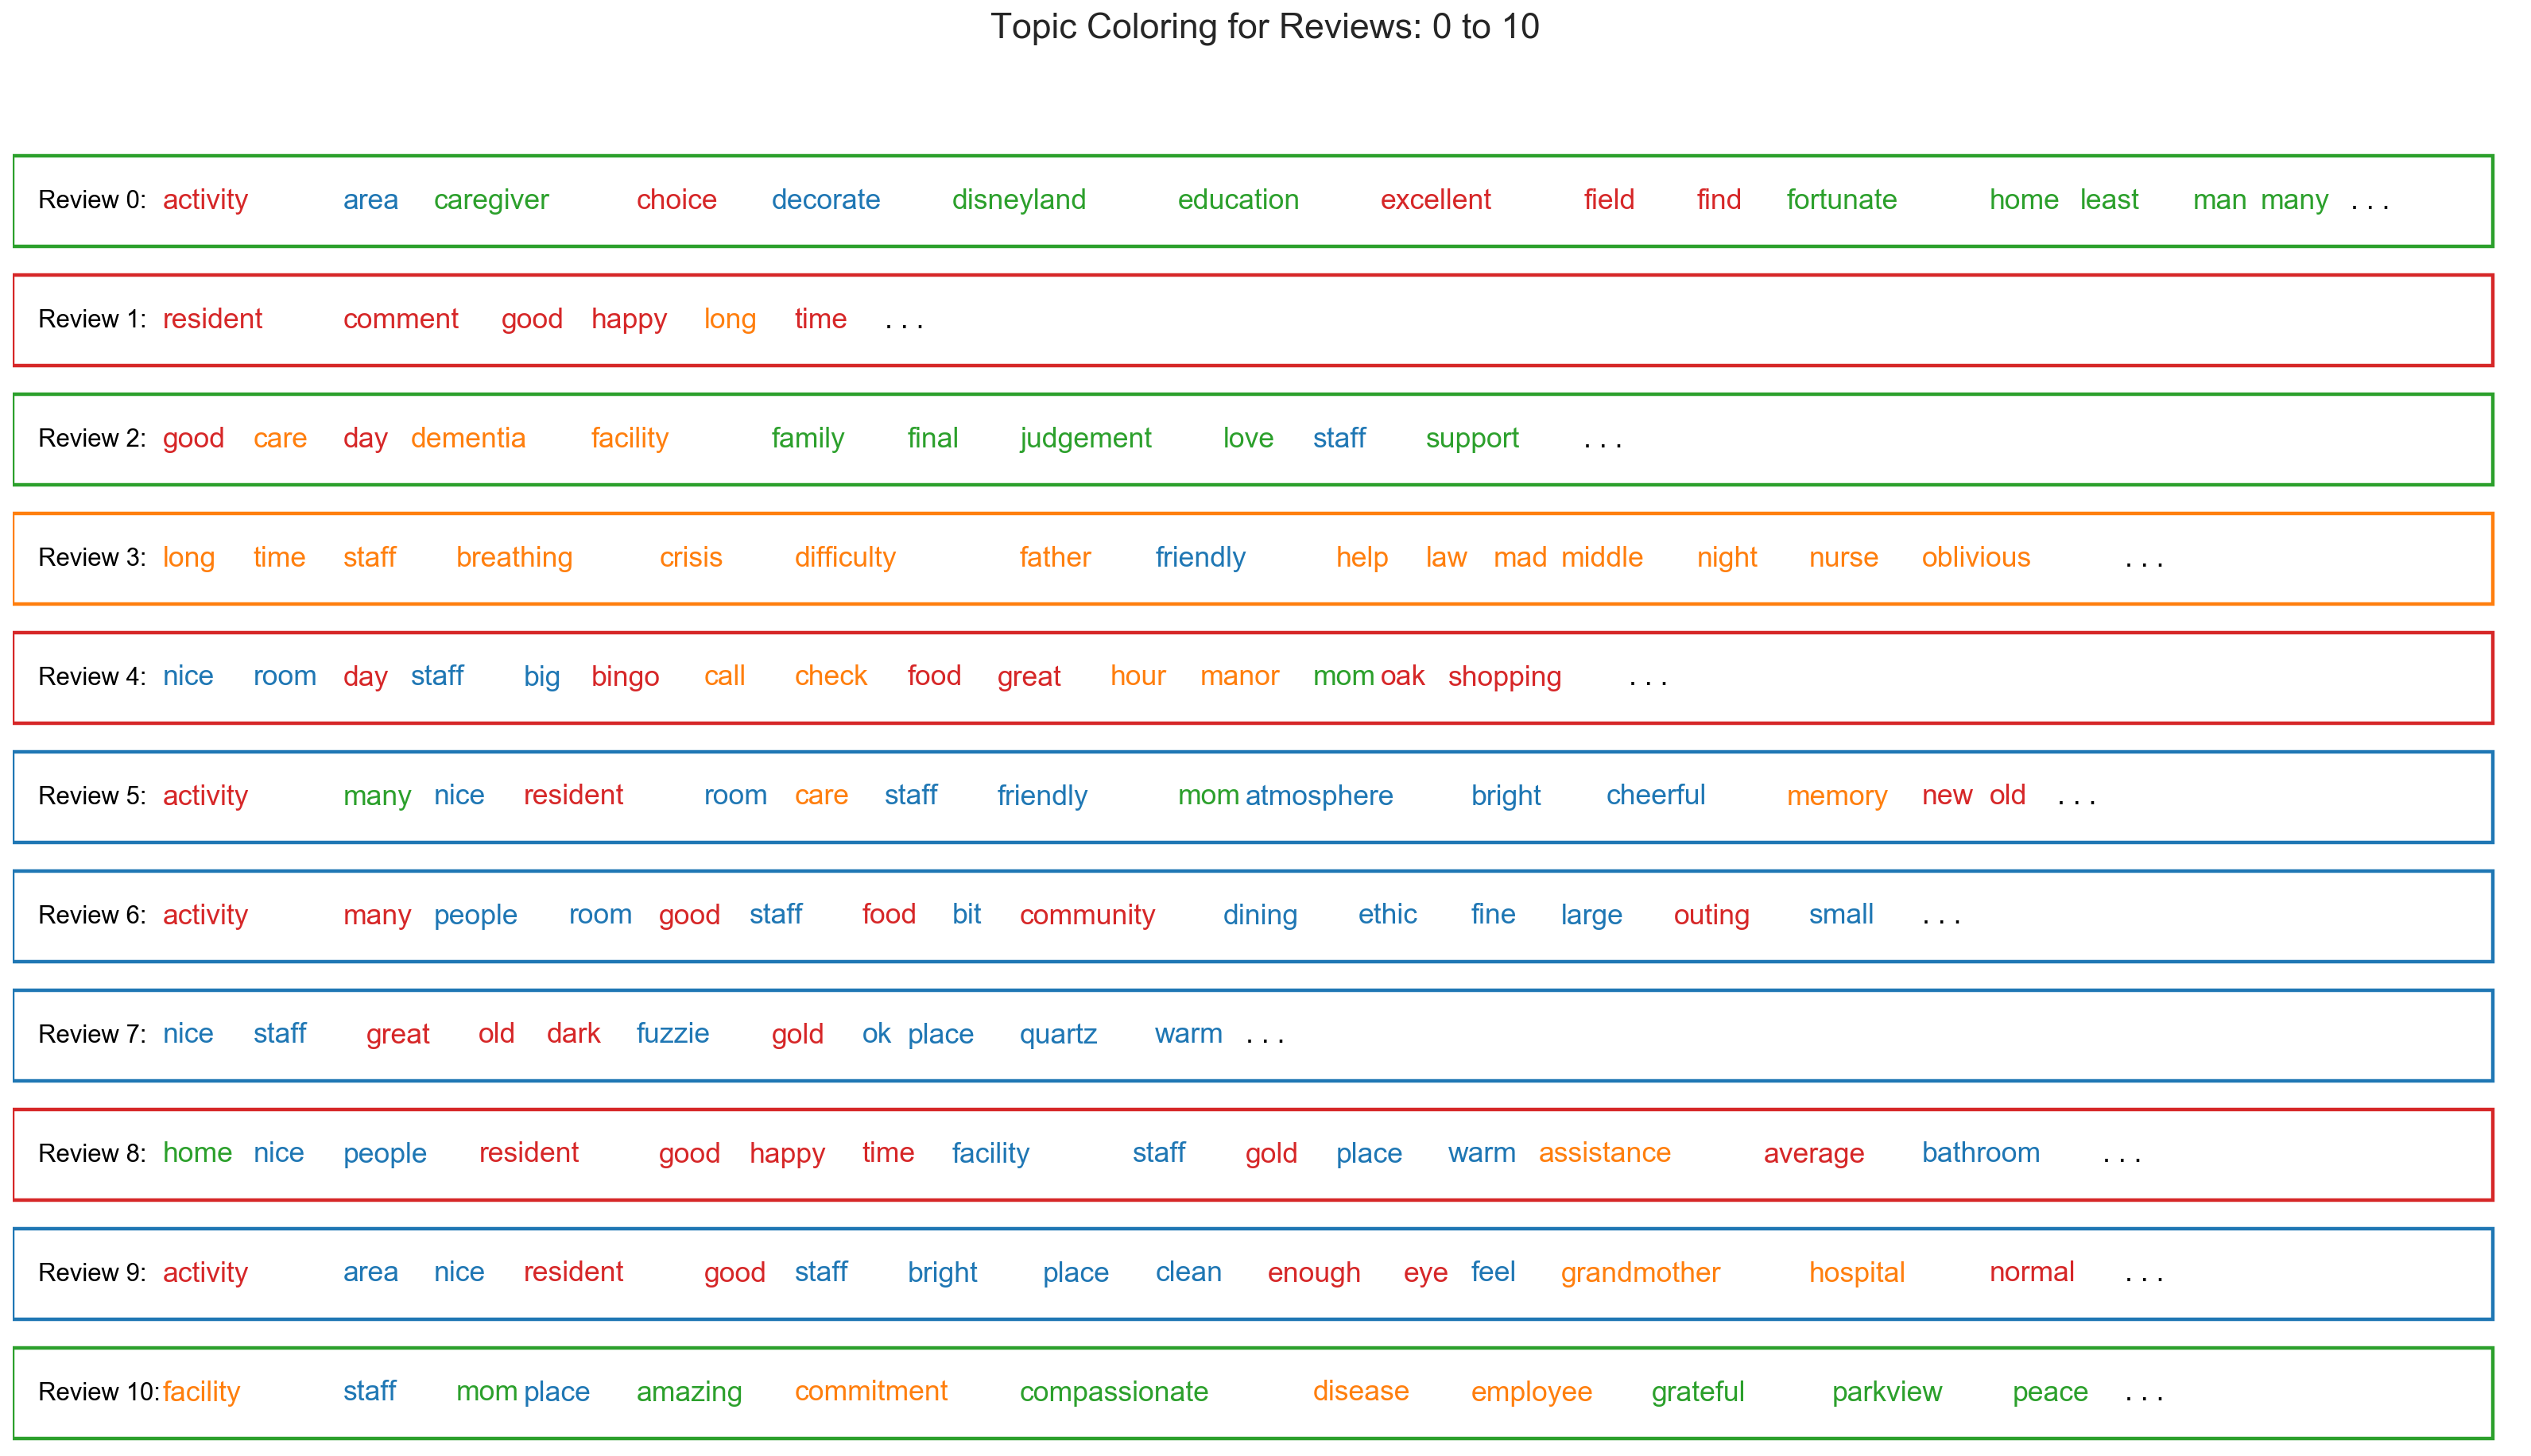

In [863]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model = lda_model, corpus = corpus, start = 0, end = 12):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize =(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            ax.text(0.01, 0.5, "Review " + str(i-1) + ": ", verticalalignment ='center',
                    fontsize = 14, color='black', transform = ax.transAxes, fontweight=400)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key = lambda x: (x[1]), reverse = True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill = None, alpha = 1, 
                                   color = mycolors[topic_percs_sorted[0][0]], linewidth = 2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 15:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment = 'left',
                            verticalalignment = 'center',
                            fontsize = 16, color = mycolors[topics],
                            transform = ax.transAxes, fontweight=400)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment = 'left',
                    verticalalignment = 'center',
                    fontsize = 16, color = 'black',
                    transform = ax.transAxes)       

    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.suptitle('Topic Coloring for Reviews: ' + str(start) + ' to ' + str(end-2), fontsize = 20, y = 1, fontweight = 500)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [864]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.3]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot);

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11980 samples in 0.013s...
[t-SNE] Computed neighbors for 11980 samples in 0.288s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11980
[t-SNE] Computed conditional probabilities for sample 2000 / 11980
[t-SNE] Computed conditional probabilities for sample 3000 / 11980
[t-SNE] Computed conditional probabilities for sample 4000 / 11980
[t-SNE] Computed conditional probabilities for sample 5000 / 11980
[t-SNE] Computed conditional probabilities for sample 6000 / 11980
[t-SNE] Computed conditional probabilities for sample 7000 / 11980
[t-SNE] Computed conditional probabilities for sample 8000 / 11980
[t-SNE] Computed conditional probabilities for sample 9000 / 11980
[t-SNE] Computed conditional probabilities for sample 10000 / 11980
[t-SNE] Computed conditional probabilities for sample 11000 / 11980
[t-SNE] Computed conditional probabilities for sample 11980 / 11980
[t-SNE] Mean sigma: 0.013582
[t-SNE] KL divergence

Loading BokehJS ...

In [38]:
#get document topics for each review
get_document_topics = [lda_model.get_document_topics(item) for item in corpus]
document_topics = []
for i in range(len(get_document_topics)):
    sorted_doc_topics  = sorted(get_document_topics[i], key = lambda x: (x[1]), reverse = True) 
    document_topics.append(sorted_doc_topics[0][0])

data['topic'] = document_topics
data.head()

,Unnamed: 0,reviewer_type,reviewer_name,date,star,review,location,name_of_senior_living,type,review length,year,review_no_contract,review_new,topic
0,0,I am a friend or relative of a current/past re...,Lizzy49,2018-07-07,5,This is a residence for mentally challenged me...,Plymouth,Schwabe Residential Home,Offers Assisted Living,736,2018,"[This, is, a, residence, for, mentally, challe...",This is a residence for mentally challenged me...,2
1,0,I visited this facility,moomamma,2014-03-06,4,I have heard such good comments about Jackson ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care,110,2014,"[I, have, heard, such, good, comments, about, ...",I have heard such good comments about Jackson ...,3
2,1,I am/was a resident of this facility,Biker_Momma45,2014-03-05,5,I had my Dad in this facility recently and he ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care,279,2014,"[I, had, my, Dad, in, this, facility, recently...",I had my Dad in this facility recently and he ...,2
3,2,I am/was a resident of this facility,solongdad,2012-09-26,3,I found not all staff friendly. One nurse was ...,Jackson,Jackson Gardens Elder Care Home,Offers Memory Care,362,2012,"[I, found, not, all, staff, friendly., One, nu...",I found not all staff friendly. One nurse was ...,1
4,0,I am a friend or relative of a current/past re...,Peggy,2018-04-30,5,"Mom really likes Oak Manor, and everything has...",Jackson,Oak Manor,Offers Assisted Living,386,2018,"[Mom, really, likes, Oak, Manor,, and, everyth...","Mom really likes Oak Manor, and everything has...",3


In [39]:
data.topic.unique()

array([2, 3, 1, 0])

# Use sklearn LDA and NMF for comparison

In [955]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))



no_features = 1000
no_topics = 4

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(data.review.values)
tfidf = tfidf_vectorizer.fit_transform(data.review)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=no_topics, random_state=100, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

no_top_words = 15
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0:
nice rooms clean area looked place staff dining friendly facility liked really helpful saw visited
Topic 1:
care facility staff residents mother home mom family great living caring memory years place happy
Topic 2:
like room people really didn just lot little living dining activities place going things don
Topic 3:
good food staff pretty activities excellent place clean people friendly brookdale happy lot really fine


In [486]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
no_topics = 4
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(data.review.values)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_components = no_topics, 
                                max_iter = 5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state = 100).fit(tf)
display_topics(lda, tf_feature_names, no_top_words)




Topic 0:
care staff facility residents home family place great caring living memory resident loved mother activities
Topic 1:
nice like room rooms place people good really staff clean dining area looked didn facility
Topic 2:
good living food activities staff assisted excellent independent apartment place community happy great meals day
Topic 3:
mom care people like mother place just good room really staff dad time food day


# Clustering

In [686]:
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
#     stems = [stemmer.stem(t) for t in filtered_tokens]
    return filtered_tokens

In [665]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                   min_df=0.2, stop_words='english',
                                   use_idf=True, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(data.review) 

#print(tfidf_matrix.shape)

CPU times: user 657 ms, sys: 23.8 ms, total: 681 ms
Wall time: 694 ms


In [667]:
print(tfidf_matrix.shape)

(11980, 17)


In [807]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 16.5 s, sys: 68 ms, total: 16.6 s
Wall time: 16.7 s


In [808]:
caring = {'title':data.name_of_senior_living, 'star':data.star, 'review':data.review, 'cluster': clusters, 'type': data.type}

#frame = pd.DataFrame(caring, index = [cluster], columns = ['star', 'title', 'cluster', 'type'])
frame = pd.DataFrame(caring,  columns = ['star', 'title', 'cluster', 'type'])
#frame = pd.DataFrame(caring, columns = ['star', 'title', 'cluster', 'type'])

In [809]:
frame['cluster'].value_counts()

1    3759
2    2751
0    2120
4    1752
3    1598
Name: cluster, dtype: int64

In [810]:
grouped = frame['star'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean()

cluster
0    4.311792
1    4.243416
2    4.350055
3    4.166458
4    4.260274
Name: star, dtype: float64

In [811]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in data.review:
    allwords_stemmed = tokenize(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

In [812]:
vocab_frame = pd.DataFrame({'words': totalvocab_stemmed}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 1169058 items in vocab_frame


In [813]:
terms = tfidf_vectorizer.get_feature_names()

In [814]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :11]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print() 
    
#    print("Cluster %d titles:" % i, end='')
#    for title in frame.title.loc[i]:
#        print(' %s,' % title, end='')
#    print() #add whitespace
    print() #add whitespace
    


Top terms per cluster:

Cluster 0 words: b'good', b'food', b'staff', b'nice', b'people', b'place', b'activities', b'room', b'really', b'clean', b'like',


Cluster 1 words: b'like', b'staff', b'place', b'room', b'residents', b'living', b'people', b'activities', b'food', b'really', b'rooms',


Cluster 2 words: b'nice', b'rooms', b'place', b'room', b'staff', b'people', b'clean', b'really', b'dining', b'like', b'activities',


Cluster 3 words: b'facility', b'staff', b'residents', b'nice', b'clean', b'living', b'like', b'rooms', b'activities', b'place', b'food',


Cluster 4 words: b'care', b'staff', b'residents', b'facility', b'living', b'place', b'good', b'like', b'activities', b'food', b'people',




In [815]:
frame

,star,title,cluster,type
0,5,Schwabe Residential Home,1,Offers Assisted Living
1,4,Jackson Gardens Elder Care Home,1,Offers Memory Care
2,5,Jackson Gardens Elder Care Home,4,Offers Memory Care
3,3,Jackson Gardens Elder Care Home,1,Offers Memory Care
4,5,Oak Manor,2,Offers Assisted Living
...,...,...,...,...
11975,4,Carmen's Care Manor #1,0,Offers Assisted Living
11976,4,Family First Home Care,0,Offers Assisted Living
11977,2,Ventura Grand Chateau,1,Offers Assisted Living and Memory Care
11978,4,Ventura Grand Chateau,0,Offers Assisted Living and Memory Care


In [868]:
data.query('topic == 3').review[4]

"Mom really likes Oak Manor, and everything has been great. She likes the food, too. She has a big, nice room with a slider where she can step out and sit outside. She is really enjoying herself. She's socializing and playing cards three hours a day. They also have bowling, bingo, and go shopping. The staff is very caring and call me back right away when I ask them to check on my mom."

# Chatbot

In [40]:
from nltk.chat.util import Chat, reflections
import random

In [41]:
reflections = {
  "i am"       : "you are",
  "i was"      : "you were",
  "i"          : "you",
  "i'm"        : "you are",
  "i'd"        : "you would",
  "i've"       : "you have",
  "i'll"       : "you will",
  "my"         : "your",
  "you are"    : "I am",
  "you were"   : "I was",
  "you've"     : "I have",
  "you'll"     : "I will",
  "your"       : "my",
  "yours"      : "mine",
  "you"        : "me",
  "me"         : "you"
}

GREETING_INPUTS = ("hello", "hi", "greetings", "sup", "what's up","hey",)
GREETING_RESPONSES = ["hi", "hey", "*nods*", "hi there", "hello", "I am glad! You are talking to me"]
def greeting(sentence):
 
    for word in sentence.split():
        if word.lower() in GREETING_INPUTS:
            return random.choice(GREETING_RESPONSES)

In [42]:
topic_1 = data.query('topic == 0').review[5]
topic_2 = data.query('topic == 1').review[18]
topic_3 = data.query('topic == 2').review[11897]
topic_4 = data.query('topic == 3').review[12]
good_review = data.query('star == 5').review[12:14].values
bad_review = data.query('star == 1').review[417:419].values


In [43]:
def response(user_response):
    bot_response = ''
    pos = ['good review', 'positive review', 'good reviews', 'positive reviews']
    neg = ['bad review', 'negative review', 'bad reviews', 'negative reviews']
    
    if 'environment' in user_response:
        bot_response = bot_response + topic_1
        return bot_response
    elif 'staff' in user_response: 
        bot_response = bot_response + topic_2
        return bot_response
    elif 'memory care' in user_response:
        bot_response = bot_response + topic_2
        return bot_response
    elif 'family' in user_response:
        bot_response = bot_response + topic_3
        return bot_response
    elif 'food' in user_response:
        bot_response = bot_response + topic_4
        return bot_response
    elif any(x in user_response for x in pos):
        bot_response = bot_response + good_review
        return bot_response
#     elif 'bad' in user_response:
    elif any(x in user_response for x in neg):
        bot_response = bot_response + bad_review
        return bot_response
    else:
        bot_response=bot_response + "I am sorry! I don't understand you. Could you please type again?"
        return bot_response

In [44]:
flag=True
print("Hi, I am Review Searching Bot. What kind of reviews can I look for you? If you want to exit, just say bye!")
while(flag==True):
    user_response = input()
    user_response=user_response.lower()
    if(user_response != 'bye'):
        if(user_response=='thanks' or user_response=='thank you' ):
            print("Bot: Anytime.. Anything else can i check for you?")
        else:
            if(greeting(user_response)!=None):
                print("Hi there. What can i do for you?", greeting(user_response), sep="\n")
            else:
                user_response
                print("Bot: ", end = "")
                print(response(user_response))

    else:
        flag=False
        print("Bot: Bye! Take care..")

Hi, I am Review Searching Bot. What kind of reviews can I look for you? If you want to exit, just say bye!
can you show me reviews about family?
Bot: Elder care is a miserable necessity. But I can confidently recommend Sunrise of Westlake Village under Director Royce, because of their current caring and clever staff. My mother with Alzheimer's has resided on the 3rd floor (Memory Care) at Sunrise for over a year. I cannot speak to the value of Sunrise's services since my father pays the bills. I am comfortable knowing my mom's physical and emotional needs are met with compassion, patience and humor here. The staff will meet with family, speak candidly - one on one and genuinely like caring for the elderly. It takes HUGE effort to visit often and to personally interact with this large staff (which is a must - anywhere). You get back what you put into this. Participating is an investment. Sunrise encourages family to join residents for meals, go on field trips, bring pets for visits and 